# Homework I - Report

Cecília Correia, 106827
<br>Patrícia Gameiro, 107245

## Programming [9v]

**Consider the diabetes.arff data available at the homework tab, comprising 8 biological
features to classify 768 patients into 2 classes (normal, diabetes).**

### 1) [1v]

**ANOVA is a statistical test that can be used to assess the discriminative power of a single input variable. Using `f_classif` from `sklearn`, identify the input variables with the worst and best discriminative power. Plot their class-conditional probability density functions.**

**Using sklearn, apply a stratified 70-30 training-testing split with a fixed seed
(`random_state=1`), and assess in a single plot the training and testing accuracies of a decision tree
with no depth limits (and remaining default behavior) for a varying number of selected features
in `{5,10,40,100,250,700}`. Feature selection should be performed before decision tree learning
considering the discriminative power of the input variables according to mutual information
criterion (`mutual_info_classif`).**

In [1]:
from scipy.io.arff import loadarff
from sklearn import model_selection, tree, metrics
from sklearn.feature_selection import f_classif
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the ARFF file
data = loadarff("./data/diabetes.arff")
df = pd.DataFrame(data[0])
df["Outcome"] = df["Outcome"].str.decode("utf-8")

In [3]:
# Separate features from the outcome 
X = df.drop("Outcome", axis = 1)
y = df["Outcome"]

In [4]:
fimportance = f_classif(X, y)

max_f_index = fimportance[0].argmax()  
min_f_index = fimportance[0].argmin()  

print(f"Best discriminative feature: {X.columns.values[max_f_index]} (F = {fimportance[0][max_f_index]})")
print(f"Worst discriminative feature: {X.columns.values[min_f_index]} (F = {fimportance[0][min_f_index]})")

Best discriminative feature: Glucose (F = 213.16175217803828)
Worst discriminative feature: BloodPressure (F = 3.256950397889028)


In [5]:
best_feature = X.columns.values[max_f_index]
worst_feature = X.columns.values[min_f_index]

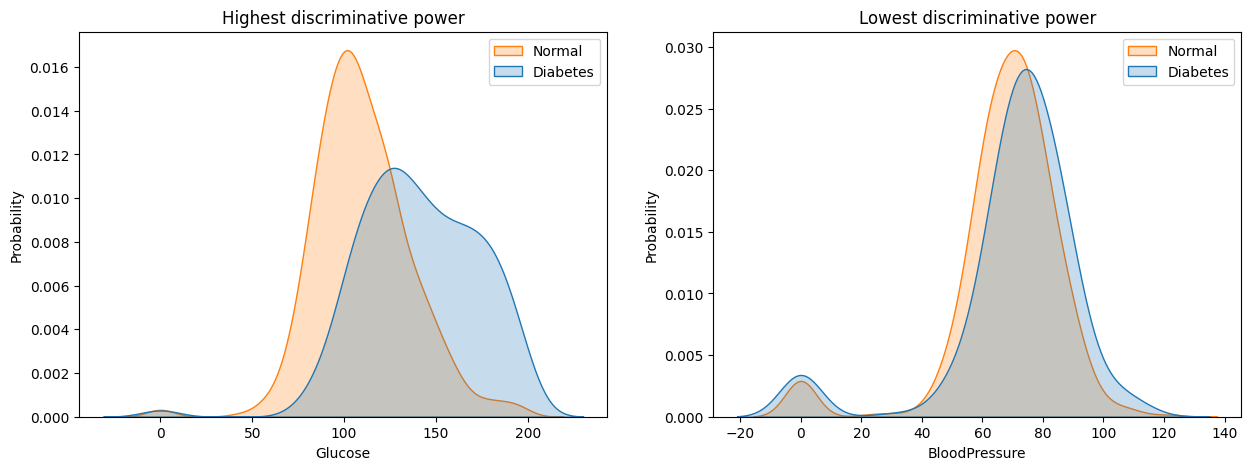

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data = df,
    x = best_feature,
    hue = "Outcome",
    fill = True,
    common_norm = False
)
plt.title("Highest discriminative power")
plt.xlabel(best_feature)
plt.ylabel("Probability")
plt.legend(("Normal", "Diabetes"))

plt.subplot(1, 2, 2)
sns.kdeplot(
    data = df,
    x = worst_feature,
    hue = "Outcome",
    fill = True,
    common_norm = False
)
plt.title("Lowest discriminative power")
plt.xlabel(worst_feature)
plt.ylabel("Probability")
plt.legend(("Normal", "Diabetes"))

plt.show()

### 2) [4v]

**Using a stratified 80-20 training-testing split with a fixed seed
(`random_state=1`), assess in a single plot both the training and testing accuracies of a decision tree with minimum sample split in `{2, 5,10, 20, 30, 50, 100}` and the remaining parameters as default.**

***[optional]* Note that split thresholding of numeric variables in decision trees is non- deterministic in sklearn, hence you may opt to average the results using 10 runs per parameterization.**

In [7]:
MIN_SAMPLES_SPLIT = [2, 5, 10, 20, 30, 50, 100] 
runs = 10  

X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, train_size = 0.8, stratify = y, random_state = 1 
        )

average_training_accuracy = []  
average_test_accuracy = []  

for min_samples_split in MIN_SAMPLES_SPLIT:
    train_acc_list = []
    test_acc_list = []

    for _ in range(runs):
        predictor = tree.DecisionTreeClassifier(min_samples_split = min_samples_split, random_state = 1)
        predictor.fit(X_train, y_train)
        
        y_train_pred = predictor.predict(X_train)
        y_test_pred = predictor.predict(X_test)

        train_acc = metrics.accuracy_score(y_train, y_train_pred)
        test_acc = metrics.accuracy_score(y_test, y_test_pred)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

    average_training_accuracy.append(np.mean(train_acc_list))
    average_test_accuracy.append(np.mean(test_acc_list))

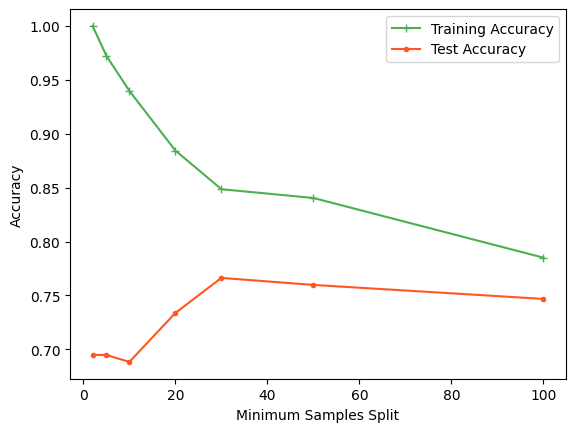

In [8]:
plt.plot(
    MIN_SAMPLES_SPLIT,
    average_training_accuracy,  
    label = "Training Accuracy",
    marker="+",
    color="#4caf50",
)
plt.plot(
    MIN_SAMPLES_SPLIT,
    average_test_accuracy,  
    label = "Test Accuracy",
    marker = ".",
    color = "#ff5722",
)

plt.xlabel("Minimum Samples Split")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


### 3) [2V]

**Critically analyze these results, including the generalization capacity across settings.**

In the results above, you can observe that the training accuracy decreases as the minimum samples split increases. However, the test accuracy initially improves and then plateaus, indicating that the model begins to generalize better as the minimum samples split increases. Eventually, though, the performance on the test set stabilizes while the training accuracy continues to drop, which may suggest that the model is becoming too simple and losing some capacity to learn more nuanced patterns in the data.

Looking at the gap between the training and test accuracy curves, we can assess the generalization capacity. A small gap with both accuracies being relatively close to each other usually signifies good generalization. In this case, the most beneficial minimum samples split appears to be around 20-50, where the test accuracy is highest and the gap between the training and test accuracy is minimized.

### 4) [2V]

**To deploy the predictor, a healthcare provider opted to learn a single decision tree (´random_state=1´) using *all* available data and ensuring that the maximum depth would be 3 in order to avoid overfitting risks.**

i. Plot the decision tree.

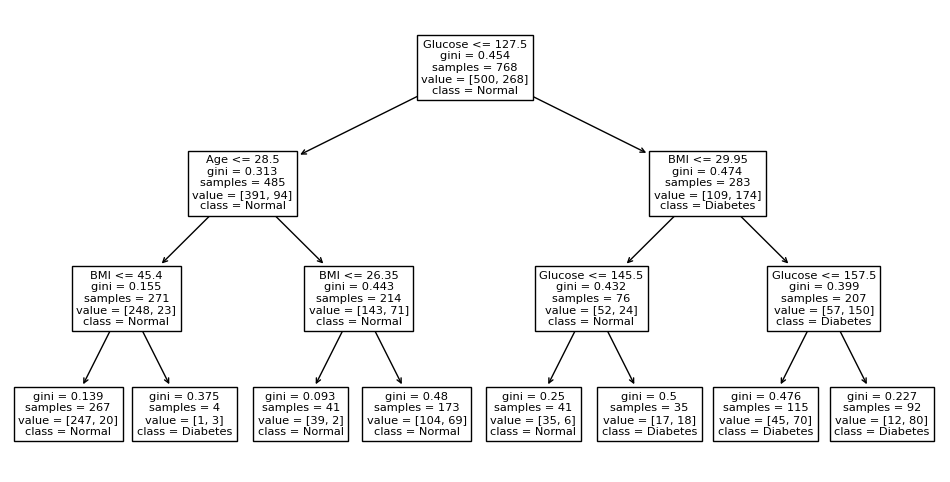

In [9]:
predictor = tree.DecisionTreeClassifier( max_depth = 3, random_state = 1)
predictor.fit(X, y)

class_names = ["Normal", "Diabetes"]  

figure = plt.figure(figsize = (12, 6))
tree.plot_tree(predictor, feature_names = X.columns.values.tolist(), class_names = class_names)

plt.show()

ii. Explain what characterizes diabetes by identifying the conditional associations together with their posterior probabilities.

The decision tree uncovers key conditional associations that distinguish diabetes from normal cases based on glucose levels, age, and BMI. Here are the posterior probabilities for diabetes at various leaf nodes:

- Leaf node for _Glucose_ ≤ 127.5 and _Age_ ≤ 28.5 and _BMI_ ≤ 45.4: 3/4 ≈ 75%

- Leaf node for _Glucose_ ≥ 127.5 and BMI ≤ 29.95 and _Glucose_ ≥ 145.5: 18/35 ≈ 51%

- Leaf node for _Glucose_ ≥ 127.5 and _BMI_ ≥ 29.95 and _Glucose_ ≤ 157.5: 70/115 ≈ 61%

- Leaf node for _Glucose_ ≥ 127.5 and _BMI_ ≥ 29.95 and _Glucose_ ≥ 157.5: 80/92 ≈ 87%

The most important predictor is glucose level: patients with glucose levels below 127.5 are predominantly classified as "Normal", indicating that lower glucose levels are associated with a lower likelihood of diabetes. Conversely, when glucose exceeds 127.5, there is a significant increase in diabetes cases. For patients with high glucose, BMI becomes a crucial factor. Individuals with a BMI above 29.95 and glucose levels higher than 157.5 have a high probability of being diagnosed with diabetes, suggesting that both high BMI and glucose are strong indicators of the disease. On the other hand, lower BMI and glucose levels are associated with a higher chance of being "Normal". These associations help predict whether a patient is likely to have diabetes, with glucose levels serving as the primary determinant, followed by BMI.